In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pyMMF.functions import colorize
import pyMMF

## Fiber parameters

In [13]:
NA = .2
n1 = 1.45
n2 = np.sqrt(n1**2 - NA**2)
wl = 1.55 # wavelength in microns
core_size = 25 # core size in microns
areaSize = 1.5*core_size # size of the grid in microns
npoints = 2**8 # number of points in the grid

## Index profile

In [14]:
# Create the fiber object
profile = pyMMF.IndexProfile(npoints = npoints, areaSize = areaSize)

In [15]:
index_array = n2*np.ones((npoints,npoints))
mask_core = (np.abs(profile.X) < core_size/2) & (np.abs(profile.Y) < core_size/2) 
index_array[mask_core] = n1
profile.initFromArray(index_array)

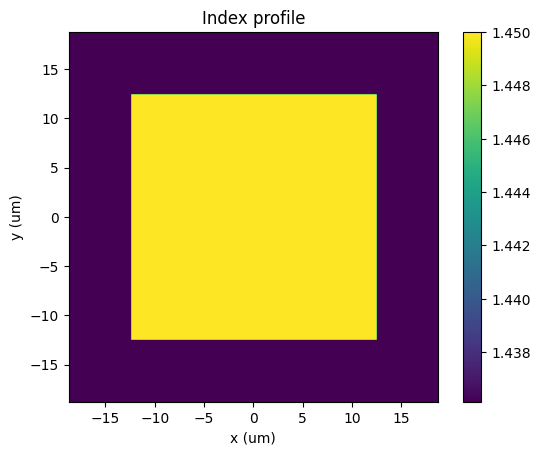

In [16]:
profile.plot()

## Radial solver

### Estimate the number of modes
see [
    *Comparison of round- and square-core fibers for sensing, imaging, and spectroscopy*, 
    Matthias C. Velsink, Zhouping Lyu, Pepijn W. H. Pinkse, and Lyubov V. Amitonova, 
    Optics Express, 
    **29**, (2021)](https://doi.org/10.1364/OE.417021)

In [21]:
k0 = 2.0 * np.pi / wl
V = k0 * core_size/2 * NA
Nmodes_estim = np.ceil(V**2 / 2.0 * 4/np.pi).astype(int) //2
# note the last division by 2 is to account for we only consider one polarization 
print(f"Estimated number of modes using the V number = {Nmodes_estim}")

Estimated number of modes using the V number = 33


## Solve the modes with the Eigen-problem solver

In [18]:
# Instantiate the solver
solver = pyMMF.propagationModeSolver()

# Set the profile to the solver
solver.setIndexProfile(profile)

# Set the wavelength
solver.setWL(wl)

Nmodes_to_compute = Nmodes_estim+10

modes = solver.solve(nmodesMax=Nmodes_estim+10,
                         boundary = 'close', 
                         mode = 'eig', 
                         curvature = None, 
                         propag_only=True)

2024-07-06 07:58:55,842 - pyMMF.core [DEBUG  ]  Debug mode ON.
2024-07-06 07:58:55,843 - pyMMF.solv [INFO   ]  Solving the spatial eigenvalue problem for mode finding.
2024-07-06 07:58:55,844 - pyMMF.solv [INFO   ]  Use close boundary condition.
2024-07-06 08:01:58,421 - pyMMF.solv [INFO   ]  Solver found 36 modes is 182.58 seconds.
2024-07-06 08:01:58,428 - pyMMF.core [DEBUG  ]  Mode data stored in memory.


In [25]:
# Be sure that we have computed enough modes
# (we discarded non-propagating modes)
assert modes.number < Nmodes_to_compute

36

## Results

### Dispersion

In [33]:
# sort modes by decreasing propagation constant
modes.sort()

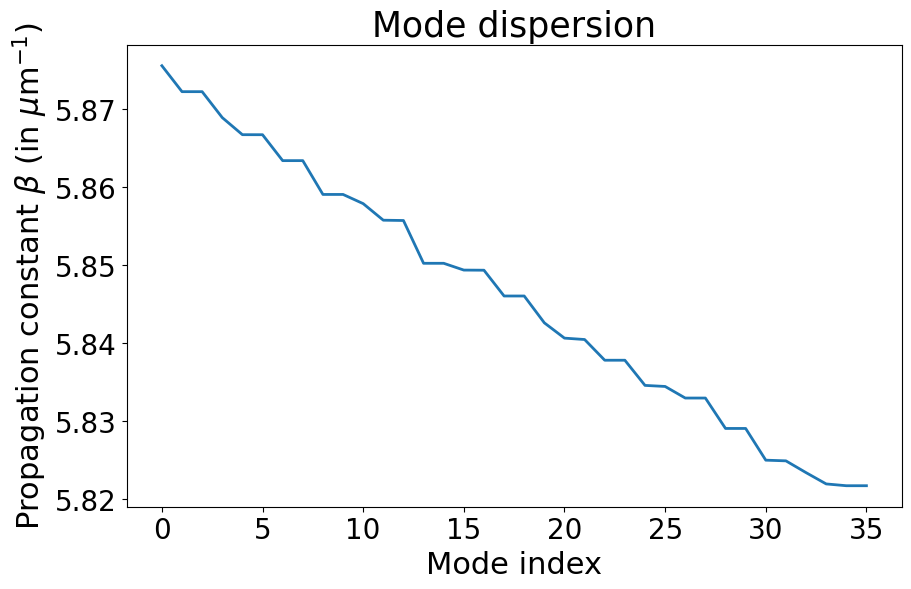

In [34]:
plt.figure(figsize=(10,6)); 
plt.plot((np.real(modes.betas)),
         linewidth=2.)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title(r'Mode dispersion' ,fontsize = 25)
plt.ylabel(r'Propagation constant $\beta$ (in $\mu$m$^{-1}$)', fontsize = 22)
plt.xlabel(r'Mode index', fontsize = 22)
plt.show()

### Display some modes

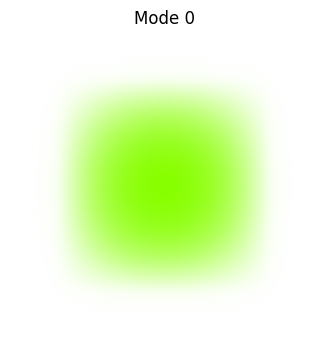

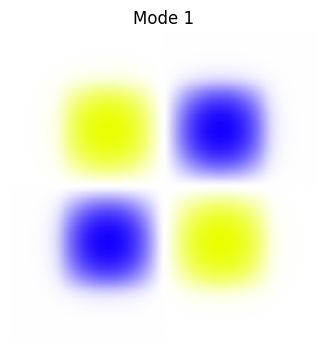

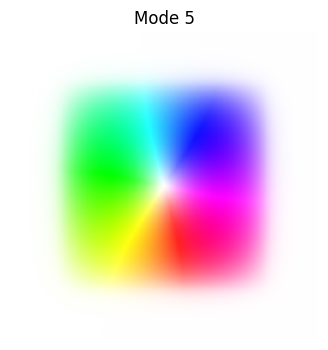

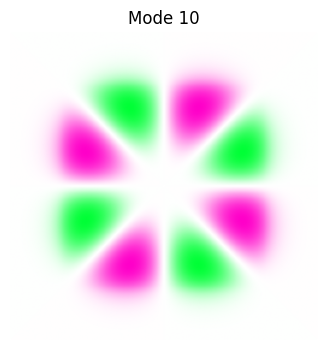

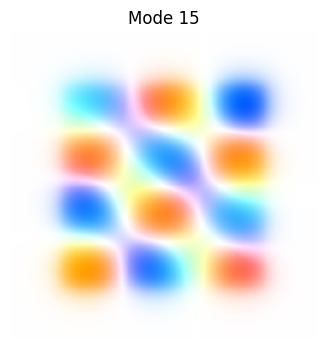

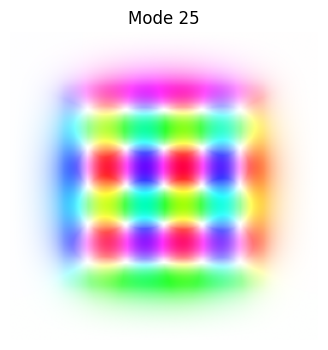

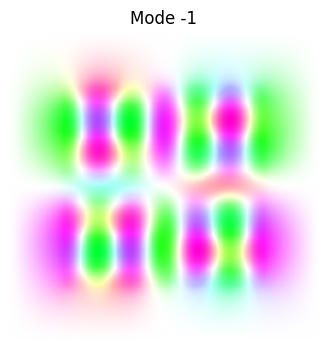

In [26]:
i_modes = [0,1,5,10,15,25,35]

M0 = modes.getModeMatrix()

for i in i_modes:
    Mi = M0[...,i]
    mode_profile = Mi.reshape([npoints]*2)
    plt.figure(figsize = (4,4))
    plt.imshow(colorize(mode_profile,'white'))
    plt.axis('off')
    plt.title(f'Mode {i}')